In [216]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from network import solve_ode_network
from scipy.signal import hilbert, butter, filtfilt
from scipy.signal import hilbert, hilbert2, savgol_filter, find_peaks
from scipy.interpolate import interp1d

In [217]:
def plot_x_values(x_values):
    j = np.array([0,20])
    fig, axes = plt.subplots(len(j), 1, figsize=(12, len(j)*3))

    for i in range(len(j)):
        axes[i].plot(x_values[:,j[i]], label=f'j={j[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(f'x_{j[i]}')
        axes[i].set_title(f'Solution of ODE for x_{j[i]}')
        axes[i].legend()

    plt.tight_layout()


In [218]:
mat = loadmat('../references/AAL78/C78.mat')
C = mat['C']

In [306]:
# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


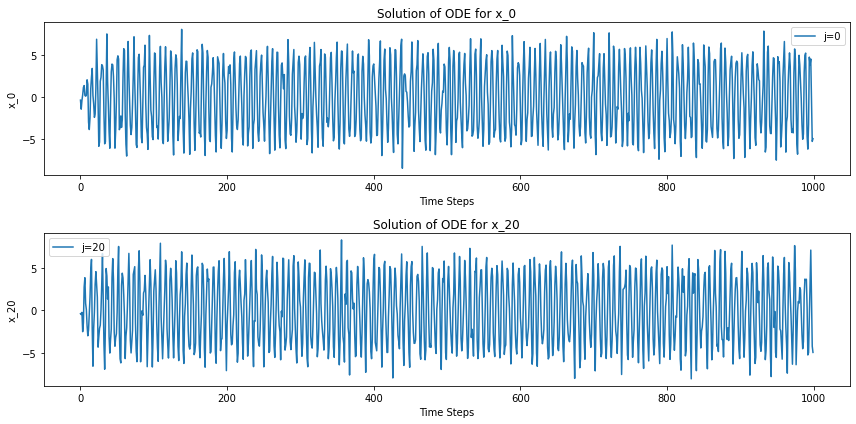

In [331]:
def signal_processing_on_hopf(C, f=12, G=0.5):   
    num_steps = 1000  # total steps
    dt = 0.01  # time step
    a = 0.0  # intrinsic dynamics parameters for each neuron
    omega = 2 * np.pi * f  # angular frequencies for each neuron
    beta = 1000  # noise level

    # Filter parameters
    fs = 1/dt
    band_lowcut = f - 2
    band_highcut = f + 2
    lowpass_cutoff = 0.2

    # Solve the ODEs
    x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

    # Preallocate arrays for filtered signals
    filtered_x = np.zeros_like(x_values)
    filtered_y = np.zeros_like(y_values)

    # Band-pass filter for each region
    for i in range(78):
        filtered_x[:, i] = bandpass_filter(x_values[:, i], band_lowcut, band_highcut, fs)
        filtered_y[:, i] = bandpass_filter(y_values[:, i], band_lowcut, band_highcut, fs)
    # plot_x_values(filtered_x)
        
    # Calculate the Hilbert transform to get the instantaneous amplitude
    analytical_x = hilbert(filtered_x)
    # print(analytical_x)
    amplitude_env_x = np.abs(analytical_x)
    # analytical_y = hilbert(filtered_y)
    # amplitude_env_y = np.abs(analytical_y)

    # Low-pass filter the amplitude envelope
    ultra_slow_x = np.zeros_like(amplitude_env_x)
    # ultra_slow_y = np.zeros_like(amplitude_env_y)
    for i in range(78):
        ultra_slow_x[:, i] = lowpass_filter(amplitude_env_x[:, i], lowpass_cutoff, fs)
        # ultra_slow_y[:, i] = lowpass_filter(amplitude_env_y[:, i], lowpass_cutoff, fs)

    return x_values, analytical_x, filtered_x, amplitude_env_x, ultra_slow_x

f=12
G=0.5
x_signal, filtered_x, analytical_x, amplitude_env_x, ultra_slow_x = signal_processing_on_hopf(C, f, G)
plot_x_values(x_signal)

In [308]:
def plot_signal_processing_stages(x_values, filtered_x, amplitude_env_x, ultra_slow_x):

    peaks, _ = find_peaks(amplitude_env_x)
    peak_interpolation = interp1d(peaks, amplitude_env_x[peaks], kind='linear', fill_value='extrapolate')
    smooth_outline = peak_interpolation(np.arange(len(filtered_x)))
    # Plot setup
    fig, axs = plt.subplots(4, 1, figsize=(12, 8))
    
    # Original signal
    axs[0].plot(x_values, label='Original Signal')
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    
    # Amplitude envelope
    axs[1].plot(amplitude_env_x, label='Amplitude Envelope', color='green')
    axs[1].set_title('Amplitude Envelope (Hilbert Transform)')
    axs[1].set_ylabel('Amplitude')
    # axs[1].legend()

    # Filtered signal
    axs[2].plot(filtered_x, label='Filtered Signal', color='orange')
    axs[2].plot(smooth_outline, label='Amplitude Envelope', color='green')
    axs[2].set_title('Band-Pass Filtered Signal')
    axs[2].set_ylabel('Amplitude')
    
    # Ultra-slow fluctuations
    axs[3].plot(ultra_slow_x, label='Ultra Slow Fluctuations', color='red')
    axs[3].set_title('Ultra-Slow Fluctuations of the Amplitude Envelope')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Amplitude')

    # Determine unified y-axis limits for the first three plots
    all_values = np.concatenate([x_values, filtered_x])
    unified_ylim = [all_values.min(), all_values.max()]

    # Setting the same y-axis limits for the first three subplots
    axs[0].set_ylim(unified_ylim)
    axs[2].set_ylim(unified_ylim)

    # Adjusting layout and showing the plot
    plt.tight_layout()
    plt.show()

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/lib/python3.9/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


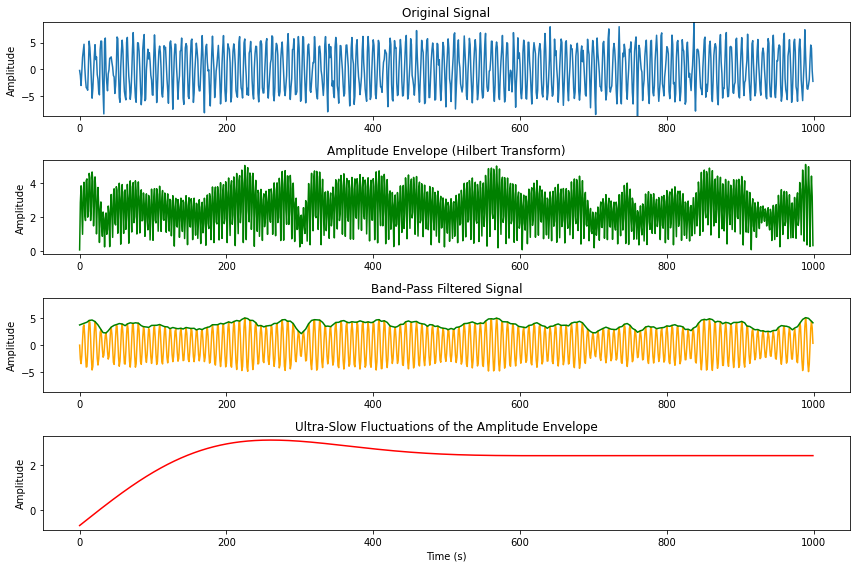

In [332]:
# def plot_for_index(index, )
index = 40
x = x_signal[:,index]

band_pass_fil = filtered_x[:, index]
amplitude_env = amplitude_env_x[:, index]
ultra_slow = ultra_slow_x[:,index]
plot_signal_processing_stages(x, band_pass_fil, amplitude_env, ultra_slow)

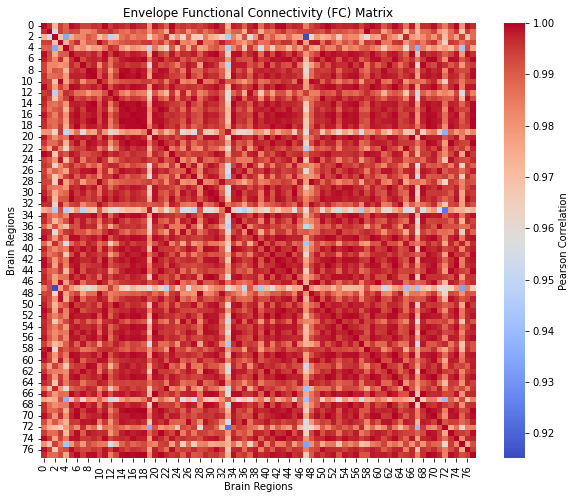

In [334]:
from scipy.stats import pearsonr
def compute_envelope_fc(ultra_slow_x):
    # Number of regions
    n_regions = ultra_slow_x.shape[1]
    
    # Initialize the FC matrix
    envelope_fc = np.zeros((n_regions, n_regions))
    
    # Compute Pearson's correlation for each pair of brain regions
    for i in range(n_regions):
        for j in range(n_regions):
            if i != j:
                corr, _ = pearsonr(ultra_slow_x[:, i], ultra_slow_x[:, j])
                envelope_fc[i, j] = corr
            else:
                envelope_fc[i, j] = 1  # Self-correlation is always 1
                
    return envelope_fc

# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(envelope_fc, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

In [325]:
# Function to calculate Kuramoto order parameter R(t) and metastability
def calculate_kuramoto_and_metastability(analytical_x):
    # Calculate the instantaneous phase φk(t) for each brain region
    instantaneous_phase = np.angle(analytical_x)

    # Calculate the Kuramoto order parameter R(t) over time
    R_t = np.abs(np.mean(np.exp(1j * instantaneous_phase), axis=1))

    # Calculate metastability as the standard deviation of the Kuramoto order parameter
    metastability = np.std(R_t)
    
    return R_t, metastability

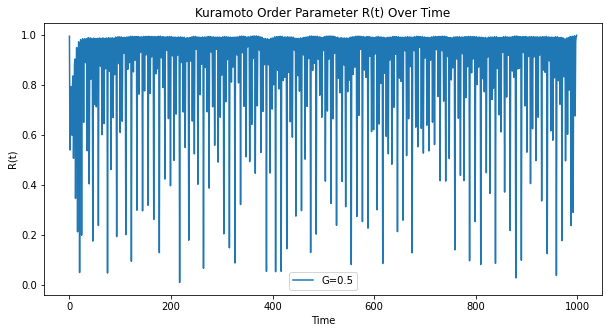

In [326]:
G = 0.5
f = 12
x_signal, analytical_x, filtered_x, amplitude_env_x, ultra_slow_x = signal_processing_on_hopf(C, f, G)
R_t, _ = calculate_kuramoto_and_metastability(analytical_x)

# Plot R_t over time
plt.figure(figsize=(10, 5))
plt.plot(R_t, label=f'G={G}')
plt.title('Kuramoto Order Parameter R(t) Over Time')
plt.xlabel('Time')
plt.ylabel('R(t)')
plt.legend()
plt.show()

/Users/shayan/Desktop/NOTTS/pbm/grp1a-Deco/PythonNotebooks/network.py:25: RuntimeWarning: overflow encountered in square
  dydt = (a - x**2 - y**2)*y + omega*x + G * np.dot(C, (y - y[:, None]).T).diagonal() + beta * noise
/Users/shayan/Desktop/NOTTS/pbm/grp1a-Deco/PythonNotebooks/network.py:26: RuntimeWarning: overflow encountered in square
  
/Users/shayan/Desktop/NOTTS/pbm/grp1a-Deco/PythonNotebooks/network.py:25: RuntimeWarning: invalid value encountered in subtract
  dydt = (a - x**2 - y**2)*y + omega*x + G * np.dot(C, (y - y[:, None]).T).diagonal() + beta * noise
/Users/shayan/Desktop/NOTTS/pbm/grp1a-Deco/PythonNotebooks/network.py:26: RuntimeWarning: invalid value encountered in subtract
  
/Users/shayan/Desktop/NOTTS/pbm/grp1a-Deco/PythonNotebooks/network.py:26: RuntimeWarning: invalid value encountered in add
  


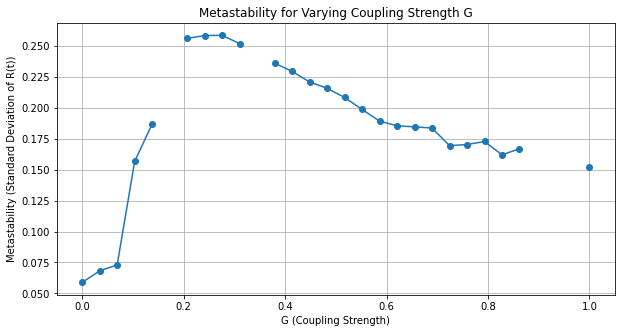

In [329]:
# Vary the coupling strength G from 0 to 1 with 30 points
G_values = np.linspace(0, 1, 30)
metastabilities = []

# Calculate metastability for varying G and plot the metastability
for G in G_values:
    _, analytical_x, filtered_x, amplitude_env_x, ultra_slow_x = signal_processing_on_hopf(C, f, G)
    _, metastability = calculate_kuramoto_and_metastability(analytical_x)
    metastabilities.append(metastability)

# Plot metastability over G values
plt.figure(figsize=(10, 5))
plt.plot(G_values, metastabilities, marker='o')
plt.title('Metastability for Varying Coupling Strength G')
plt.xlabel('G (Coupling Strength)')
plt.ylabel('Metastability (Standard Deviation of R(t))')
plt.grid(True)
plt.show()